In [1]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os 
os.chdir('/content/drive/MyDrive/PhoBERT/Sentiment analysis')

In [3]:
!pip install transformers

     |████████████████████████████████| 2.1MB 18.4MB/s 
     |████████████████████████████████| 901kB 55.7MB/s 
     |████████████████████████████████| 3.3MB 53.3MB/s 


In [4]:
!pip install sentencepiece

     |████████████████████████████████| 1.2MB 18.4MB/s 


In [5]:
!pip install fastBPE
!pip install fairseq

  Created wheel for fastBPE: filename=fastBPE-0.1.0-cp37-cp37m-linux_x86_64.whl size=483075 sha256=b9d0e25f448750e3210495fb6a662f30c8d4d8bfe3a36607a072e8f610b7739f
  Stored in directory: /root/.cache/pip/wheels/f3/0c/9c/fc62058b4d473a5602bcd3d3edfece796f123875379ea82d79
Successfully built fastBPE
     |████████████████████████████████| 1.7MB 17.9MB/s 
     |████████████████████████████████| 133kB 54.1MB/s 
     |████████████████████████████████| 61kB 8.5MB/s 
     |████████████████████████████████| 112kB 60.1MB/s 
     |████████████████████████████████| 645kB 52.9MB/s 
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.8-cp37-none-any.whl size=141231 sha256=80442b3272c933b52cd162ef9e9c24d366565a8c5cf8024eb3a41089812ae969
  Stored in directory: /root/.cache/pip/wheels/e3/e2/fa/b78480b448b8579ddf393bebd3f47ee23aa84c89b6a78285c8
Successfully built antlr4-python3-runtime
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully u

In [6]:
!pip install vncorenlp

     |████████████████████████████████| 2.7MB 21.0MB/s 
  Created wheel for vncorenlp: filename=vncorenlp-1.0.3-cp37-none-any.whl size=2645936 sha256=8d0ec5bcefba7024cd7261ac4cccba5710e42f7b74f468abb336af36feedbed8
  Stored in directory: /root/.cache/pip/wheels/09/54/8b/043667de6091d06a381d7745f44174504a9a4a56ecc9380c54
Successfully built vncorenlp


In [7]:
from vncorenlp import VnCoreNLP
rdrsegmenter = VnCoreNLP("/content/drive/MyDrive/PhoBERT/Sentiment analysis/vncorenlp/VnCoreNLP-1.1.1.jar", annotators="wseg", max_heap_size='-Xmx500m') 

text = "Đại học Bách Khoa Hà Nội."

word_segmented_text = rdrsegmenter.tokenize(text) 
print(word_segmented_text)

[['Đại_học', 'Bách_Khoa', 'Hà_Nội', '.']]


In [8]:
from fairseq.data.encoders.fastbpe import fastBPE
from fairseq.data import Dictionary
import argparse
parser = argparse.ArgumentParser()
parser.add_argument('--bpe-codes', 
    default="/content/drive/MyDrive/PhoBERT/Sentiment analysis/PhoBERT_base_transformers/bpe.codes",
    required=False,
    type=str,
    help='path to fastBPE BPE'
)
args, unknown = parser.parse_known_args()
bpe = fastBPE(args)

# Load the dictionary
vocab = Dictionary()
vocab.add_from_file("/content/drive/MyDrive/PhoBERT/Sentiment analysis/PhoBERT_base_transformers/dict.txt")

In [9]:
bpe.encode('Hôm_nay trời nóng quá nên tôi ở nhà viết Viblo!')

'Hôm_nay trời nóng quá nên tôi ở nhà viết Vi@@ blo@@ !'

In [10]:
vocab.encode_line('<s> ' + 'Hôm_nay trời nóng quá nên tôi ở nhà viết Vi@@ blo@@ !' + ' </s>')

tensor([    0,  3791,  1027,   898,   204,    77,    70,    25,    69,   467,
         3696, 16856,   381,     2,     2], dtype=torch.int32)

In [11]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences

from transformers import *
import numpy as np
import argparse
from tqdm import tqdm 
import random
import transformers
import pandas as pd
from collections import Counter
from transformers import get_linear_schedule_with_warmup
import sys
sys.argv=['']
del sys

In [12]:
df = pd.read_csv('combine.csv')
X = df['sentence'].values
Y = df['label'].values
index = np.arange(X.shape[0])
np.random.shuffle(index)
X = X[index]
Y = Y[index]

In [13]:
import numpy as np
# import unidecode
import pandas as pd
import string
import re
import os
import shutil
import pickle 

In [14]:
def transform(x):
  return [s.lower() for s in x] 
def remove_duplicate(x):
  result = []
  for s in x:
      s = re.sub(r'([a-z])\1+', lambda m: m.group(1), s, flags=re.IGNORECASE)
      s = re.sub(r'([a-z][a-z])\1+', lambda m: m.group(1), s, flags=re.IGNORECASE)
      result.append(s)
  return result

In [15]:
X = transform(X)
X = remove_duplicate(X)

In [16]:
import re
import pickle  

with open('Emoticon_Dict.p', 'rb') as fp:
    Emoticon_Dict = pickle.load(fp)

def remove_emoticons(text):
    emoticon_pattern = re.compile(u'(' + u'|'.join(k for k in Emoticon_Dict) + u')')
    return emoticon_pattern.sub(r'', text)

remove_emoticons("Good Morning :-)")

'Good Morning '

In [17]:
text_train = []
for text in X:
  text_train.append(remove_emoticons(text))

In [18]:
emoji_descriptions = pd.read_csv('emojilist.csv',index_col=False)
emoji_descriptions.head()

,emoji,description
0,😀,mặt cười toe toét
1,😃,khuôn mặt cười toe toét với đôi mắt to
2,😄,khuôn mặt cười toe toét với đôi mắt cười
3,😁,khuôn mặt rạng rỡ với đôi mắt cười
4,😆,mặt cười toe toét


In [19]:
emoji_dict = {}
emoji_descriptions.shape

(1719, 2)

In [20]:
for i in range(emoji_descriptions.shape[0]):
  emoji_dict[emoji_descriptions['emoji'][i]] = emoji_descriptions['description'][i]

In [21]:
def convert_emojis_to_word(text):
    for emot in emoji_dict:
      if emot in text:
        text = re.sub(r'('+emot+')', ' '+emoji_dict[emot], text)
    return text

In [22]:
final_text = []
for text in text_train:
  final_text.append(convert_emojis_to_word(text))

In [23]:
final_text

['gà chiên kỹ ( hoặc nhiều lần  nên có màu nâu sậm . miếng gà khá là bé và xương rất giòn\ncoca khá đc\nkhoai ổn . cắt to hơn loteria or kfc .\nkhông gian rộng rãi .\nthái độ nhân viên ổn\ngiá hơi cao so vs sản phẩm',
 'sốt chocolate ăn chung với whiping cream wán này ăn ghiền cực . mocha vừa , không quá ngọt nên cực hợp với phần kem nha .',
 'nhìn giá cả có vè vừa , đồ ăn đúng chất hq , nhiều món cay chịu không nổi luôn .\nvì không thích ăn kiểu đông người nên tụi mình đi lúc 4 giờ chiều , nhân viên nhiệt tình , hỏi gì cũng vui vẻ trả lời .\năn no cành bụng luôn ý : 3\nsẽ quay lại để thử nhiều món khác : 3',
 'ăn buổi tối bát phở tái tại đây . bánh phở thái tay , sợi phở không ngấm gia vị lắm . giá 35k hơi chát so với giá phở tái bình quân . đi ngang đường đói thì ăn , nói chung sẽ không quay lại .',
 'quán nhỏ , mình đến khoảng 3-4h mấy nên vắng teo , nhân viên thấy khách vào thì tắt máy lạnh ? ? ? trong quán rất nóng , mình xem qua menu thấy giá cũng oke , gọi 1 phần sandwich strawb

In [24]:
X = final_text
X

['gà chiên kỹ ( hoặc nhiều lần  nên có màu nâu sậm . miếng gà khá là bé và xương rất giòn\ncoca khá đc\nkhoai ổn . cắt to hơn loteria or kfc .\nkhông gian rộng rãi .\nthái độ nhân viên ổn\ngiá hơi cao so vs sản phẩm',
 'sốt chocolate ăn chung với whiping cream wán này ăn ghiền cực . mocha vừa , không quá ngọt nên cực hợp với phần kem nha .',
 'nhìn giá cả có vè vừa , đồ ăn đúng chất hq , nhiều món cay chịu không nổi luôn .\nvì không thích ăn kiểu đông người nên tụi mình đi lúc 4 giờ chiều , nhân viên nhiệt tình , hỏi gì cũng vui vẻ trả lời .\năn no cành bụng luôn ý : 3\nsẽ quay lại để thử nhiều món khác : 3',
 'ăn buổi tối bát phở tái tại đây . bánh phở thái tay , sợi phở không ngấm gia vị lắm . giá 35k hơi chát so với giá phở tái bình quân . đi ngang đường đói thì ăn , nói chung sẽ không quay lại .',
 'quán nhỏ , mình đến khoảng 3-4h mấy nên vắng teo , nhân viên thấy khách vào thì tắt máy lạnh ? ? ? trong quán rất nóng , mình xem qua menu thấy giá cũng oke , gọi 1 phần sandwich strawb

In [25]:
train_text = []
for text in X:
  text = rdrsegmenter.tokenize(text)
  text = ' '.join([' '.join(x) for x in text])
  train_text.append(text)

In [26]:
train_text

['gà chiên kỹ ( hoặc nhiều lần nên có màu nâu sậm . miếng gà khá là bé và xương rất giòn coca khá đc khoai ổn . cắt to hơn loteria or kfc . không_gian rộng_rãi . thái_độ nhân_viên ổn giá hơi cao so vs sản_phẩm',
 'sốt chocolate ăn chung với whiping cream wán này ăn ghiền cực . mocha vừa , không quá ngọt nên cực hợp với phần kem nha .',
 'nhìn giá_cả có vè vừa , đồ_ăn đúng chất hq , nhiều món cay chịu không nổi luôn . vì không thích ăn kiểu đông người nên tụi mình đi lúc 4 giờ chiều , nhân_viên nhiệt_tình , hỏi gì cũng vui_vẻ trả_lời . ăn no cành bụng luôn ý : 3 sẽ quay lại để thử nhiều món khác : 3',
 'ăn buổi tối bát phở tái tại đây . bánh_phở thái tay , sợi phở không ngấm gia_vị lắm . giá 35k hơi chát so với giá phở tái bình_quân . đi ngang đường đói thì ăn , nói_chung sẽ không quay lại .',
 'quán nhỏ , mình đến khoảng 3-4 h mấy nên vắng_teo , nhân_viên thấy khách vào thì tắt máy_lạnh ? ? ? trong quán rất nóng , mình xem qua menu thấy giá cũng oke , gọi 1 phần sandwich strawbery giá 

In [27]:
train_label = Y
train_label

array([0, 2, 2, ..., 2, 0, 0])

In [28]:
from sklearn.model_selection import train_test_split
train_sents, val_sents, train_labels, val_labels = train_test_split(train_text,train_label,test_size=0.3)

In [29]:
import collections
from collections import Counter
Counter(train_label)

Counter({0: 15775, 1: 515, 2: 16822})

In [30]:
Counter(train_labels)

Counter({0: 11060, 1: 370, 2: 11748})

In [31]:
Counter(val_labels)

Counter({0: 4715, 1: 145, 2: 5074})

In [32]:
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras.preprocessing.sequence import pad_sequences

train_ids = []
for sent in train_sents:
  subwords = '<s>' + bpe.encode(sent) + '/<s>'
  encoded_sent = vocab.encode_line(subwords, append_eos=True, add_if_not_exist=False).long().tolist()
  train_ids.append(encoded_sent)

val_ids = []
for sent in val_sents:
  subwords = '<s>' + bpe.encode(sent) + '/<s>'
  encoded_sent = vocab.encode_line(subwords, append_eos=True, add_if_not_exist=False).long().tolist()
  val_ids.append(encoded_sent)

In [33]:
sent_len = [len(x) for x in train_ids]

In [34]:
max(sent_len)

746

In [35]:
min(sent_len)

2

In [36]:
len(train_ids)

23178

In [37]:
len(val_ids)

9934

In [38]:
count = 0
for x in sent_len:
  if 0<x<110:
    count+=1
count

22971

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


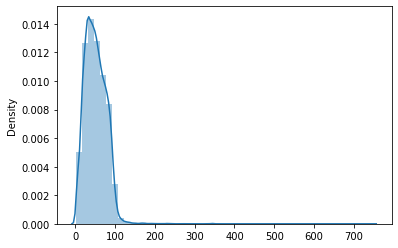

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.distplot(sent_len)
plt.show()

In [40]:
MAX_LEN = 120
train_ids = pad_sequences(train_ids, maxlen=MAX_LEN, dtype="long", value=0, truncating="post", padding="post")
val_ids = pad_sequences(val_ids, maxlen=MAX_LEN, dtype="long", value=0, truncating="post", padding="post")

In [41]:
train_masks = []
val_masks = []
for id in train_ids:
  mask = [int(token_id > 0) for token_id in id]
  train_masks.append(mask)

for id in val_ids:
  mask = [int(token_id > 0) for token_id in id]
  val_masks.append(mask)

In [42]:
print(len(train_masks[0]))

120


In [43]:
from torch.utils.data import TensorDataset,DataLoader,RandomSampler,SequentialSampler
import torch
train_inputs = torch.tensor(train_ids)
val_inputs = torch.tensor(val_ids)
train_labels = torch.tensor(train_labels)
val_labels = torch.tensor(val_labels)
train_masks = torch.tensor(train_masks)
val_masks = torch.tensor(val_masks)

train_data = TensorDataset(train_inputs,train_masks,train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=32)

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = RandomSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=32)

In [44]:
from transformers import RobertaForSequenceClassification, RobertaConfig, AdamW

config = RobertaConfig.from_pretrained(
    "/content/drive/MyDrive/PhoBERT/Sentiment analysis/PhoBERT_base_transformers/config.json", from_tf=False, num_labels = 3, output_hidden_states=False,
)
BERT_SA = RobertaForSequenceClassification.from_pretrained(
    "/content/drive/MyDrive/PhoBERT/Sentiment analysis/PhoBERT_base_transformers/model.bin",
    config=config
)

You are using a model of type bert to instantiate a model of type roberta. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at /content/drive/MyDrive/PhoBERT/Sentiment analysis/PhoBERT_base_transformers/model.bin were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.decoder.bias', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSe

In [45]:
BERT_SA.cuda()

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(64001, 768, padding_idx=0)
      (position_embeddings): Embedding(258, 768, padding_idx=0)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerN

In [46]:
import numpy as np 
from sklearn.metrics import accuracy_score,f1_score

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    
    F1_score = f1_score(pred_flat, labels_flat, average='macro')
    
    return accuracy_score(pred_flat, labels_flat), F1_score

In [47]:
import random
from tqdm import tqdm_notebook
device = 'cuda'
epochs = 4

param_optimizer = list(BERT_SA.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5, correct_bias=False)
# total_steps = len(train_dataloader) * epochs
# scheduler = get_linear_schedule_with_warmup(optimizer,
#                                             num_warmup_steps = int(0.1*total_steps),
#                                             #warmup_steps = 0, # Default value in run_glue.py
#                                             num_training_steps = total_steps)
#                                             #t_total = total_steps)
                                            
for epoch_i in range(0, epochs):
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    total_loss = 0
    BERT_SA.train()
    train_accuracy = 0
    nb_train_steps = 0
    train_f1 = 0
    
    for step, batch in tqdm_notebook(enumerate(train_dataloader)):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        BERT_SA.zero_grad()
        outputs = BERT_SA(b_input_ids, 
            token_type_ids=None, 
            attention_mask=b_input_mask, 
            labels=b_labels)
        loss = outputs[0]
        total_loss += loss.item()
        
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        tmp_train_accuracy, tmp_train_f1 = flat_accuracy(logits, label_ids)
        train_accuracy += tmp_train_accuracy
        train_f1 += tmp_train_f1
        nb_train_steps += 1
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(BERT_SA.parameters(), 1.0)
        optimizer.step()
        
    avg_train_loss = total_loss / len(train_dataloader)
    print(" Accuracy: {0:.4f}".format(train_accuracy/nb_train_steps))
    print(" F1 score: {0:.4f}".format(train_f1/nb_train_steps))
    print(" Average training loss: {0:.4f}".format(avg_train_loss))

    print("Running Validation...")
    BERT_SA.eval()
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    eval_f1 = 0
    for batch in tqdm_notebook(val_dataloader):

        batch = tuple(t.to(device) for t in batch)

        b_input_ids, b_input_mask, b_labels = batch

        with torch.no_grad():
            outputs = BERT_SA(b_input_ids, 
            token_type_ids=None, 
            attention_mask=b_input_mask)
            logits = outputs[0]
            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()

            tmp_eval_accuracy, tmp_eval_f1 = flat_accuracy(logits, label_ids)

            eval_accuracy += tmp_eval_accuracy
            eval_f1 += tmp_eval_f1
            nb_eval_steps += 1
    print(" Accuracy: {0:.4f}".format(eval_accuracy/nb_eval_steps))
    print(" F1 score: {0:.4f}".format(eval_f1/nb_eval_steps))
print("Training complete!")

======== Epoch 1 / 4 ========
Training...


__main__:31: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



 Accuracy: 0.8528
 F1 score: 0.7440
 Average training loss: 0.3758
Running Validation...


__main__:65: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



 Accuracy: 0.8817
 F1 score: 0.7922
======== Epoch 2 / 4 ========
Training...



 Accuracy: 0.9039
 F1 score: 0.8346
 Average training loss: 0.2641
Running Validation...



 Accuracy: 0.8837
 F1 score: 0.8096
======== Epoch 3 / 4 ========
Training...



 Accuracy: 0.9252
 F1 score: 0.8894
 Average training loss: 0.2142
Running Validation...



 Accuracy: 0.8897
 F1 score: 0.8165
======== Epoch 4 / 4 ========
Training...



 Accuracy: 0.9434
 F1 score: 0.9162
 Average training loss: 0.1720
Running Validation...



 Accuracy: 0.8829
 F1 score: 0.8054
Training complete!
